# How does the performance of a distributional model change as we train in on more and more labelled data?

 - Pennington el al (2014) report `word2vec`'s performance at the word analogy task and a range of word similarity task improves with more data. 
 - My own experiments (in `euroscipy_demo` notebook) show performance at the analogy task roughly scales like $log(x)$

Let's investigate if the same holds for the document classification task. For simiplicity, we only look at `word2vec` vectors with simple composion on the Reuters data set.

In [5]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *

/Users/miroslavbatchkarov/NetBeansProjects/ExpLosion


In [17]:
def get_exp_ids_for_varying_amounts_of_unlabelled(corpus='amazon_grouped-tagged'):
    query_dict = {'expansions__vectors__rep': 0, 
                  'expansions__k':3,
                  'labelled':corpus,
                'expansions__use_similarity': 0, 
                'expansions__neighbour_strategy':'linear',
                'expansions__vectors__dimensionality': 100, 
                'document_features_ev': 'AN+NN', 
                'document_features_tr': 'J+N+AN+NN', 
                'expansions__allow_overlap': False,
                'expansions__entries_of': None,
                #           'vectors__unlabelled_percentage__in': [70,80], # todo remove this
                'expansions__vectors__algorithm': 'word2vec',
                'expansions__vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # todo Verb???
                'expansions__vectors__unlabelled': 'wiki',
                'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
                'expansions__noise': 0}
    return Experiment.objects.filter(**query_dict).order_by('expansions__vectors__unlabelled_percentage',
                                                           'expansions__vectors__composer').values_list('id', flat=True)

# `word2vec` learning curve on Gigaword

In [29]:
corpus='amazon_grouped-tagged'
ids = get_exp_ids_for_varying_amounts_of_unlabelled()
print(len(ids), 'ids in total:', ids)
df = dataframe_from_exp_ids(ids, {'Composer':'expansions__vectors__composer',
                                   'percent':'expansions__vectors__unlabelled_percentage'})
df[df.folds==0].to_html('tmp.html')

48 ids in total: [88, 108, 98, 118, 89, 109, 99, 119, 46, 48, 47, 49, 90, 110, 100, 120, 91, 111, 101, 121, '...(remaining elements truncated)...']
score has 24000 values
folds has 24000 values
percent has 24000 values
Composer has 24000 values


[(0, 48), (1, 48)]

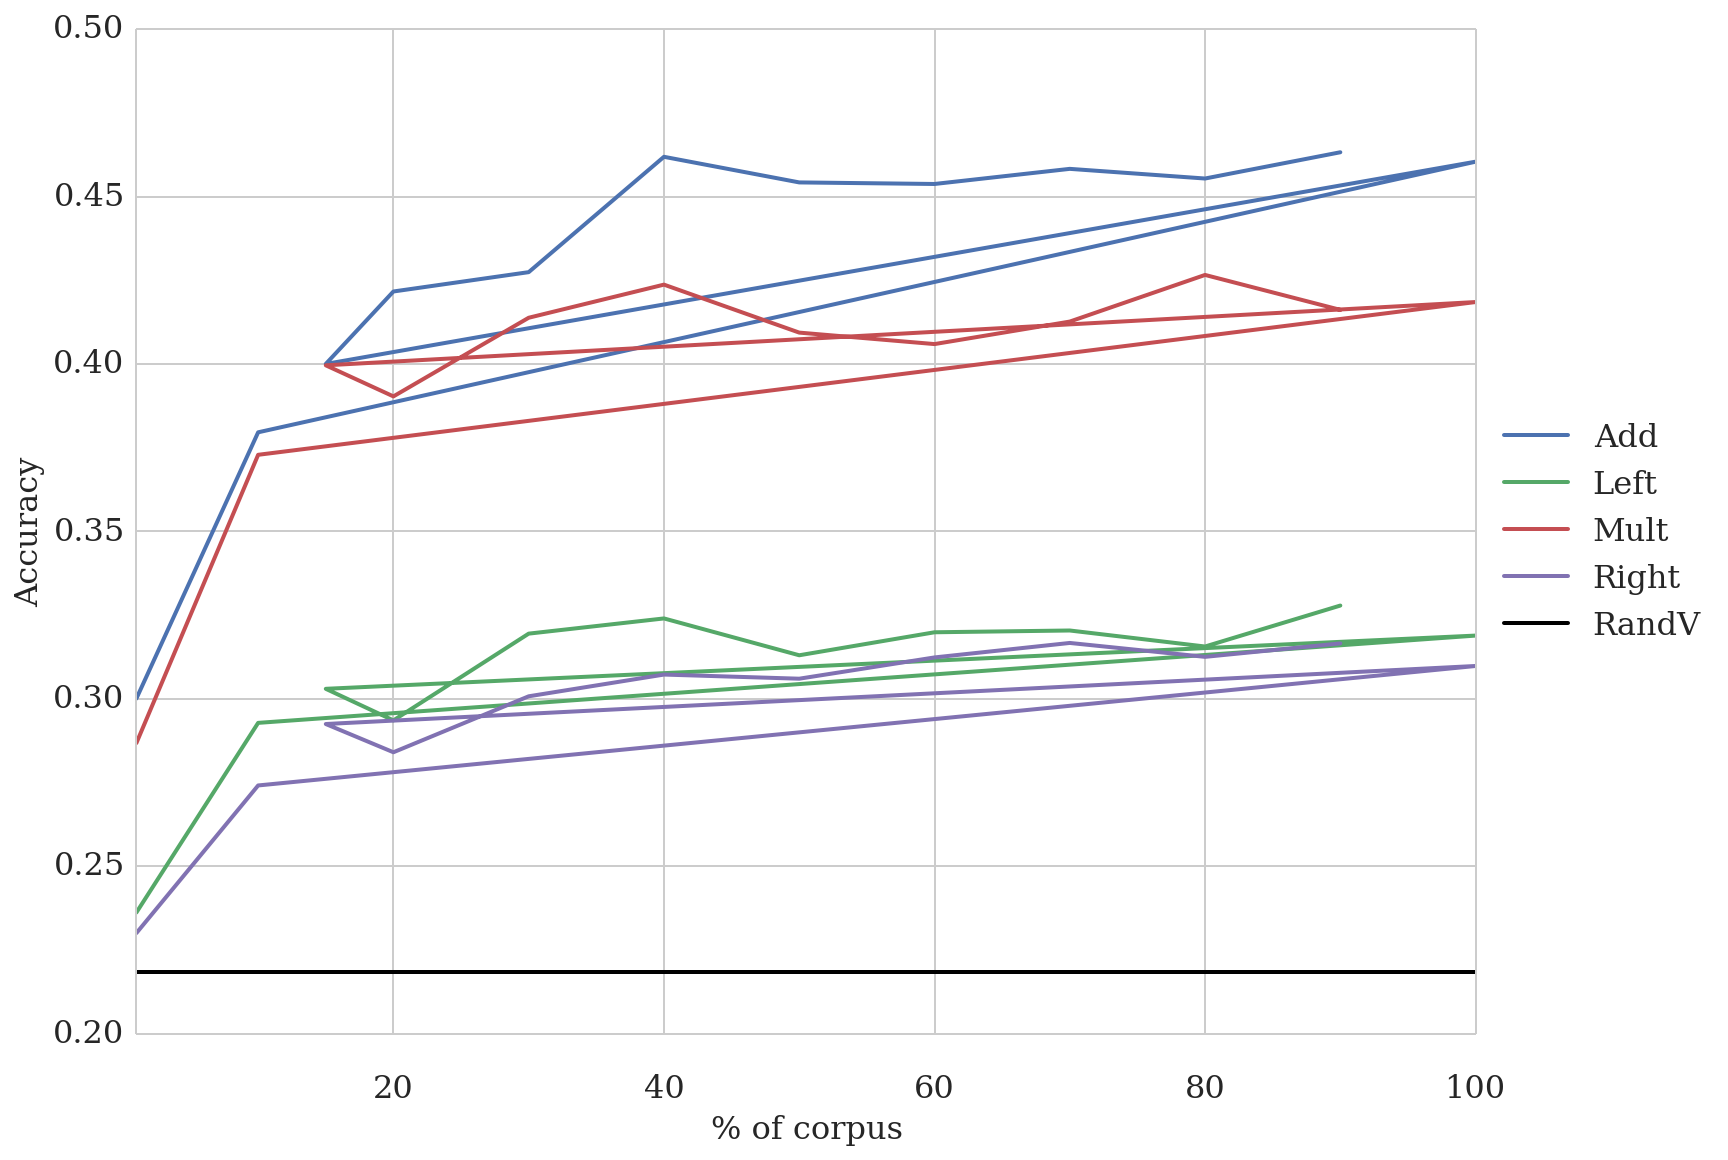

In [33]:
ax = sns.tsplot(df, time='percent', condition='Composer', value='score', unit='folds',
                err_style=['ci_bars'], n_boot=1);
# _ = ax.set_title('Performance vs Amount of unlabelled data');
# _ = ax.set(ylim=(.5, .8)) 
# _ = ax.set(xlim=(None, 10)) # zoom in on the left hand size

# remove axis labels  
ax.set(xlabel='% of corpus', ylabel='Accuracy')

# random baseline
plt.axhline(random_vect_baseline(), label='RandV', color='black')
plt.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
plt.savefig('plot-w2v_learning_curve_amazon.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

 - some variation introduced by classification task
   - each run has a different vocabulary
   - different set of candidate neighbours that can be inserted at decode time

ValueError: First argument must be a sequence

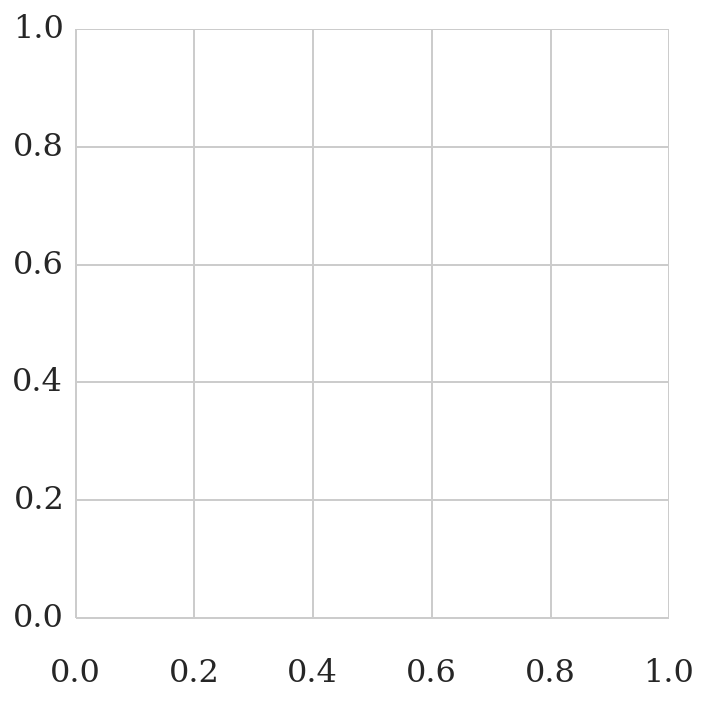

In [25]:
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.labelsize'] = 16

# do main plot
df['Algorithm'] = df.Composer
g = sns.lmplot('percent', 'score', df, hue='Algorithm', lowess=True, 
               line_kws={"linewidth": 4}, # line size
               legend=False, # hide legend for now, I'll show it later
               aspect=1);

labels = np.arange(0, 101, 20) * 0.01 * 1.5 # convert percent of corpus to a rough token count
g.set(xlim=(0,100), xticklabels=labels, xlabel='Token count, B')

# add random baseline
plt.axhline(random_vect_baseline(), color='k', label='RandV');

# add a legend with extra bits and bobs
plt.legend(markerscale=3,
           bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3,
           ncol=2,
           borderaxespad=0.)
g.savefig('plot-w2v_learning_curve_amazon2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

#---------------------------------------------------------------------------
#---------------------------------------------------------------------------
# Notes on code below
In earlier iterations of this experiment we used Reuters data, where there was large variation between accuracies of multiple runs of the `word2vec`. The code below looks into why that might be the case. These differences no longer exist, so the code below is probably useless.

# Why is multiply so unstable?
Things to look at
- <s>compare vectors between multiple runs (before and after composition)</s>. The space is completely different, this makes no sense.
 - compare neighbours of a sample of entries between runs
  - without any constraints, out of the full vocabulary
  - out of the neighbours present in the labelled data set
      - redoing experiments [218, 313, 314] and [225, 315, 316] with stats enabled. These are word2vec repeated runs at 100% of gigaw with Add/Mult composer respectively
  
- Could the whole variation be simply down to the small size of Reuters? Would using Amazon help? 
  - in general error bounds due to classification task are much smaller on Amazon (~1%) as apposed to ~3-4% on Reuters

- Performance of `w2v` models I've trained on google's analogy task
    - can't easily calculate as I have stemmed and added a pos tar => syntactic part of test is impossible to do
    - compute something like Precision@K/MAP instead of accuracy of top neighbour

In [6]:
# Compare unigram vectors between multiple runs
from glob import glob
from discoutils.thesaurus_loader import Vectors as V
pattern = '/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-100perc.unigr.strings.rep*'
# pattern = '/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-100perc.unigr.strings.rep*'
files = sorted(glob(pattern))
thes = [V.from_tsv(f) for f in files]

INFO:	Loading thesaurus /mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-100perc.unigr.strings.rep0 from disk
INFO:	Loading thesaurus /mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-100perc.unigr.strings.rep1 from disk
INFO:	Loading thesaurus /mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-100perc.unigr.strings.rep2 from disk


In [7]:
# all 3 runs should contain the same entries
assert all(x.keys() == thes[0].keys() for x in thes)
assert all(len(x) == len(thes[0]) for x in thes)

from scipy.spatial.distance import cosine, euclidean
from itertools import combinations
from random import sample

pairs = []
sims = []
s = sample([x for x in thes[0].keys() if x[-1] in 'NJ'], 500)
for i,j in combinations(range(len(thes)), 2):
    print('Doing pair %d and %d'%(i,j))
    d = [euclidean(thes[i].get_vector(foo).A, 
                   thes[j].get_vector(foo).A) for foo in s] # cosine distance
    sims.extend(d)
    pairs.extend(['%d-%d'%(i,j)]*(len(sims) - len(pairs)))

Doing pair 0 and 1
Doing pair 0 and 2
Doing pair 1 and 2


# Overlap of neighbours for $word_i$ across `word2vec` runs
Dice coefficient over a small sample, neighbours selected out of the entire `word2vec` vocabulary

In [8]:
def dice(n1, n2):
    return 2 * len(set(n1) & set(n2))/ (len(n1) + len(n2))

for t in thes:
    t.init_sims()
pairs = []
sims = []
s = sample([x for x in thes[0].keys() if x[-1] in 'NJ'], 500)
for i,j in combinations(range(len(thes)), 2):
    print('Doing pair %d and %d'%(i,j))
    for num, foo in enumerate(s):
        n1 = [x[0] for x in thes[i].get_nearest_neighbours(foo)[:10]]
        n2 = [x[0] for x in thes[j].get_nearest_neighbours(foo)[:10]]
        sims.append(dice(n1, n2))
    pairs.extend(['%d-%d'%(i,j)]*(len(sims) - len(pairs)))

Doing pair 0 and 1
Doing pair 0 and 2
Doing pair 1 and 2


In [9]:
df3 = pd.DataFrame({'Pair': pairs,
                   'Dice': sims,
                   'Words' : s * 3})
g = sns.FacetGrid(df3, col="Pair");
g.map(sns.distplot, 'Dice');

 - Neighbour do not overlap much (not to mention their order)
 - Should I report averaged performance across all runs of `word2vec`?
 
If the neighbours vary so much, why is the performance of some composers so stable? 
  - Do some composers "magnify" differences in input vectors?
  - Is it a matter of vocabulary coverage? the neighbours that we find here are different to the one the classifier finds

# Neighbours selected from ones in vocabulary (fold 0)

In [19]:
from thesisgenerator.scripts.analysis.signified_internals_analysis import get_replacements_df
from itertools import product

def get_neigh_from_df(df, feature):
    recorded_replacements = []
    for i in range(1, 4):
        r = df.loc[feature]['replacement%d' % i]
        if r:  # remove NaN
            recorded_replacements.append(r)
    return recorded_replacements

try:
    repl1 = get_replacements_df('statistics/stats-exp218-0-cv0-ev.par.csv') # todo hardcoded values, see above
    repl2 = get_replacements_df('statistics/stats-exp225-0-cv0-ev.par.csv')
except FileNotFoundError as e:
    raise ValueError('Cant find file')
assert set(repl1.index) == set(repl2.index)
s = sample(list(repl2.index), 100)
overlap = [dice(get_neigh_from_df(repl1, foo),
                get_neigh_from_df(repl2, foo)) for foo in s]
# print(len(composers), len(reps), len(overlap))
plt.hist(overlap, bins=4);
plt.xticks(np.arange(3)/3);

/Volumes/LocalDataHD/mmb28/anaconda/envs/py33/lib/python3.3/site-packages/matplotlib/__init__.py:1156: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Volumes/LocalDataHD/mmb28/anaconda/envs/py33/lib/python3.3/site-packages/pandas/io/parsers.py:635: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)
